### 0. Import libraries and import data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path


# Add the directory to sys.path
import sys
module_path = Path('./../code')
sys.path.append(str(module_path))
import utils

### 1. Clean the cancer registry data

In [2]:
# Define directory path variable
directory = Path('./../data/')

# Define file name variable
filename = 'ugicancer_registry.xlsx'
export_filename = 'ugicancer_registry_clean.csv'

# Rename the columns
rename_cols = {
    'MEDRECNO': 'mrn',
    'Date of Diagnosis': 'date_dx',
    'Date of Contact': 'date_contact', 
    'LNAME': 'name_last', 
    'FNAME': 'name_first',
    'date of birth': 'dob', 
    'Tumor Site': 'tumor_site', # Based on ICD 03 codes
    'Histology': 'histology', # Based on ICD 03 codes
    'PRIMARY_TUMOR_SITE': 'primary_tumor_site',
    'BEHAVIOR': 'behavior'
}

In [3]:
# Read the Excel file into a pandas dataframe
file_path = directory / filename
df = pd.read_excel(file_path)
df.rename(columns=rename_cols, inplace=True)

In [4]:
# Convert text columns to lowercase
text_columns = df.select_dtypes(include=['object']).columns 
df[text_columns] = df[text_columns].applymap(lambda x: x.lower() if isinstance(x, str) else x)

/var/folders/2m/nz3ptmfs6c586nfvk00y2dsc0000gp/T/ipykernel_82886/1968360442.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[text_columns] = df[text_columns].applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [5]:
df.primary_tumor_site.value_counts()

primary_tumor_site
stomach            1597
small intestine     671
esophagus           476
Name: count, dtype: int64

In [6]:
# Convert date columns from integers to datetime
df['datetime_contact'] = pd.to_datetime(df['date_contact'].astype(int), format='%Y%m%d')
df['datetime_dob'] = pd.to_datetime(df['dob'].astype(int), format='%Y%m%d')

#### Clean up the dates of cancer diagnosis because they are not in consistent formats. 
1. Create a new datetime column for diagnosis and automatically set default date as Jan 1st if month/date not provided. 
2. Create a boolean column to indicate when we set default date. 

Eventually, we will want to correlate with MRNs to see if these patients have encounters in our system at least 6 months before the date of diagnosis. Perhaps these patients were all diagnosed outside of sinai. 

This is one of the reasons for excluding patients with UGI diagnosis within 6 months after the first encounter. 

Bucket Table:
     bucket  count
0      yyyy     87
1  yyyymmdd   2654


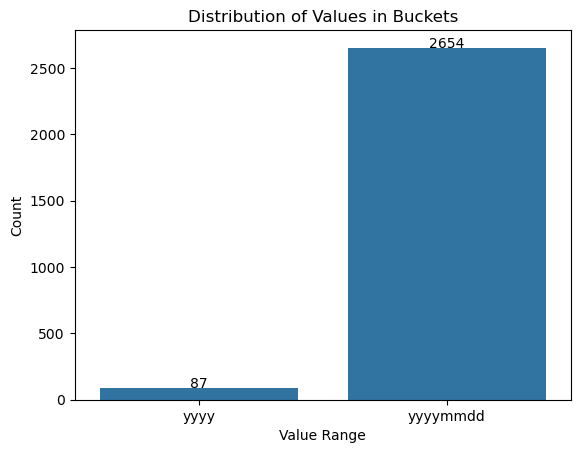

In [7]:
# Generate a barplot to show the distribution and counts of year-only and year-mon-day values in the dataset
utils.generate_bucket_barplot(df['date_dx'], [1000, 3000, 30000000], ['yyyy', 'yyyymmdd'])

In [8]:
# Create a new datetime column for diagnosis and automatically set default date as Jan 1st if month/date not provided. 
df['datetime_dx'] = df['date_dx'].apply(utils.convert_date_dx)

# Create a column to indicate when we set default date.  
df['datetime_dx_real'] = np.where(df['date_dx'] > 300000, 1, 0)

### Determine UGI cancer subtypes based on tumor site and histology ICD codes

In [9]:
""" Define the ICD-10 codes and their descriptions
{
    # Esophagus 
    'C150': 'Malignant neoplasm: Cervical part of oesophagus', 
    'C151': 'Malignant neoplasm: Thoracic part of oesophagus', 
    'C152': 'Malignant neoplasm: Abdominal part of oesophagus', 
    'C153': 'Malignant neoplasm: Upper third of oesophagus', 
    'C154': 'Malignant neoplasm: Middle third of oesophagus', 
    'C155': 'Malignant neoplasm: Lower third of oesophagus', 
    'C158': 'Malignant neoplasm: Overlapping lesion of oesophagus', 
    'C159': 'Malignant neoplasm: Oesophagus, unspecified', 
    # Stomach 
    'C160': 'Malignant neoplasm: Cardia', 
    'C161': 'Malignant neoplasm: Fundus of stomach', 
    'C162': 'Malignant neoplasm: Body of stomach', 
    'C163': 'Malignant neoplasm: Pyloric antrum', 
    'C164': 'Malignant neoplasm: Pylorus', 
    'C165': 'Malignant neoplasm: Lesser curvature of stomach, unspecified', 
    'C166': 'Malignant neoplasm: Greater curvature of stomach, unspecified', 
    'C168': 'Malignant neoplasm: Overlapping lesion of stomach', 
    'C169': 'Malignant neoplasm: Stomach, unspecified', 
    # Small intestine 
    'C170': 'Malignant neoplasm: Duodenum', 
    'C171': 'Malignant neoplasm: Jejunum', 
    'C172': 'Malignant neoplasm: Ileum', 
    'C173': 'Malignant neoplasm: Meckel diverticulum', 
    'C178': 'Malignant neoplasm: Overlapping lesion of small intestine', 
    'C179': 'Malignant neoplasm: Small intestine, unspecified'
} """

" Define the ICD-10 codes and their descriptions\n{\n    # Esophagus \n    'C150': 'Malignant neoplasm: Cervical part of oesophagus', \n    'C151': 'Malignant neoplasm: Thoracic part of oesophagus', \n    'C152': 'Malignant neoplasm: Abdominal part of oesophagus', \n    'C153': 'Malignant neoplasm: Upper third of oesophagus', \n    'C154': 'Malignant neoplasm: Middle third of oesophagus', \n    'C155': 'Malignant neoplasm: Lower third of oesophagus', \n    'C158': 'Malignant neoplasm: Overlapping lesion of oesophagus', \n    'C159': 'Malignant neoplasm: Oesophagus, unspecified', \n    # Stomach \n    'C160': 'Malignant neoplasm: Cardia', \n    'C161': 'Malignant neoplasm: Fundus of stomach', \n    'C162': 'Malignant neoplasm: Body of stomach', \n    'C163': 'Malignant neoplasm: Pyloric antrum', \n    'C164': 'Malignant neoplasm: Pylorus', \n    'C165': 'Malignant neoplasm: Lesser curvature of stomach, unspecified', \n    'C166': 'Malignant neoplasm: Greater curvature of stomach, unspec

In [10]:
# Creates a second column that checks tumor site ICD code to classify stomach into cardia, noncardia vs unspecified
df['primary_tumor_site_2'] = df.apply(utils.get_tumorsite_stomach, axis=1)
# Creates a third column that checks histology ICD codes to classify into primary EAC, ESCC, CGC and NCGC
df['subtype'] = df.apply(utils.get_cancer_subtype, axis=1)

In [11]:
# There remain some unclassified subtypes that did not fit
# Export these counts into a .txt file and .csv file to investigate to make sure we are not missing any histology ICD codes 
df_notclassified = df[['subtype', 'tumor_site', 'histology']]
print(df_notclassified[df_notclassified.subtype.isin(['NCGC', 'ESCC', 'CGC', 'EAC'])].subtype.value_counts())
df_notclassified[~df_notclassified.subtype.isin(['NCGC', 'ESCC', 'CGC', 'EAC'])].subtype.value_counts()

subtype
NCGC    614
ESCC    237
CGC     224
EAC     197
Name: count, dtype: int64


subtype
small intestine         671
stomach, unspecified    476
stomach, noncardia      240
stomach, cardia          43
esophagus                42
Name: count, dtype: int64

In [12]:
df_notclassified = df[~df.subtype.isin(['NCGC', 'CGC', 'EAC', 'ESCC'])].sort_values(by=['subtype', 'tumor_site', 'histology'])[['subtype', 'tumor_site', 'histology']].drop_duplicates()
df_notclassified.to_csv(directory / 'ugicancer_registry_notclassified.csv')

In [ ]:
# One hot encoding for the subtypes
df['ugica_ESCC'] = np.where(df.subtype == 'ESCC', 1, 0)
df['ugica_EAC'] = np.where(df.subtype == 'EAC', 1, 0)
df['ugica_CGC'] = np.where(df.subtype == 'CGC', 1, 0)
df['ugica_NCGC'] = np.where(df.subtype == 'NCGC', 1, 0)

### Export the dataset

In [14]:
columns_of_interest = ['mrn',
       'datetime_contact', 'datetime_dob', 'datetime_dx', 'datetime_dx_real', 
       'primary_tumor_site', 'primary_tumor_site_2', 'histology', 'subtype', 
       'ugica_ESCC', 'ugica_EAC', 'ugica_CGC', 'ugica_NCGC']
final_df = df[columns_of_interest]
print(final_df.datetime_dx.min(), final_df.datetime_dx.max())

1976-01-01 00:00:00 2023-09-07 00:00:00


In [ ]:
final_df.to_csv(directory / export_filename, index=False) # Do not include the row indices as a separate column.

,mrn,datetime_contact,datetime_dob,datetime_dx,datetime_dx_real,primary_tumor_site,primary_tumor_site_2,histology,subtype,ugica_ESCC,ugica_EAC,ugica_CGC,ugica_NCGC
0,38814,2022-06-29,1942-12-07,2022-06-29,1,small intestine,small intestine,8140,small intestine,0,0,0,0
1,106779,2022-06-08,1968-10-09,2022-06-08,1,stomach,"stomach, noncardia",8140,NCGC,0,0,0,1
2,108594,2016-08-11,1946-02-09,2016-08-11,1,stomach,"stomach, noncardia",8936,"stomach, noncardia",0,0,0,0
3,118072,2019-01-07,1961-06-20,2019-01-07,1,esophagus,esophagus,8070,ESCC,1,0,0,0
4,126066,2018-02-01,1971-08-16,2018-01-09,1,stomach,"stomach, cardia",8140,CGC,0,0,1,0
